In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances

In [3]:
env_steps = Concept.load_concept_data()

In [4]:
#model_path = QNetwork.find_newest_model()
model_path = "runs/20240317-112025/model_10000000.pt"
model = QNetwork(model_path=model_path)
layer = 4

Loaded model: 20240317-112025-10000000


Concept: random binary


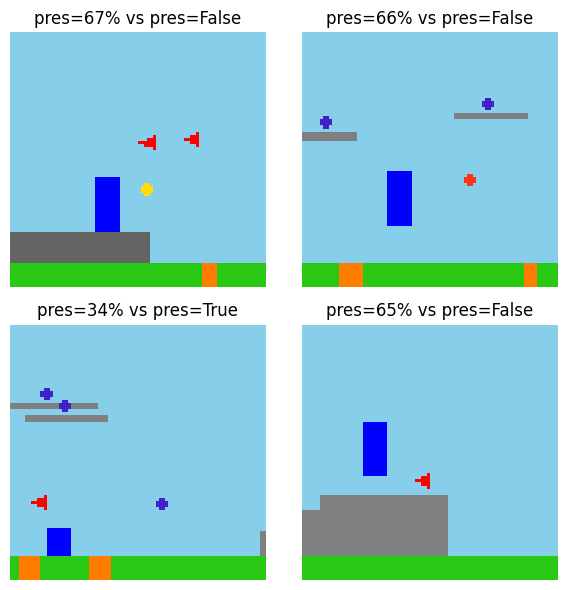

Concept: random continuous


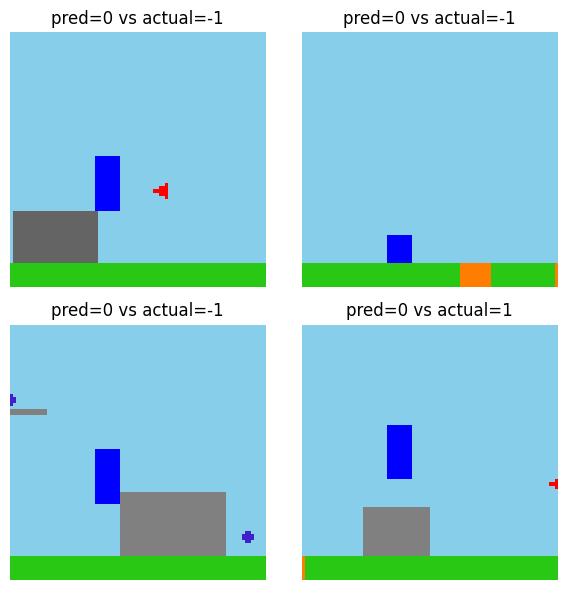

Concept: total wall area


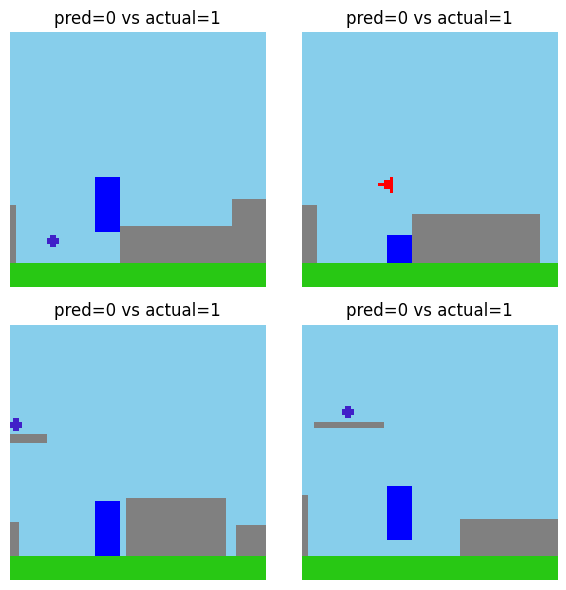

Concept: player on grass


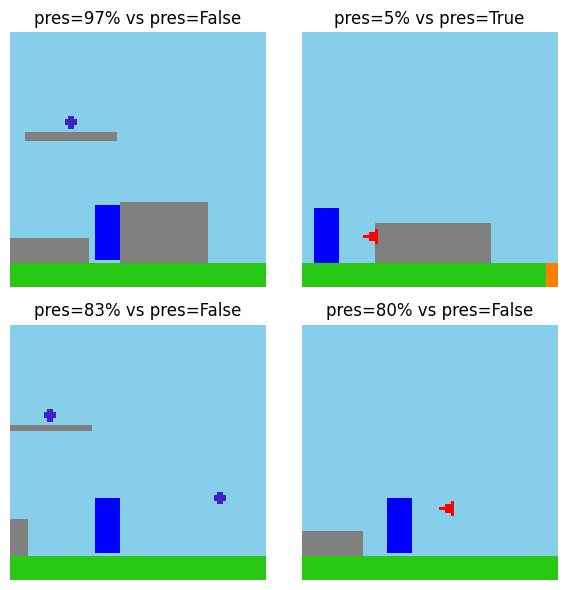

Concept: player in air


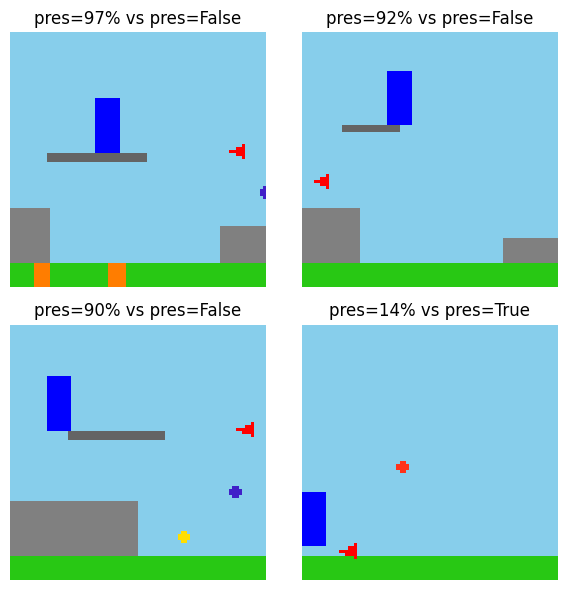

Concept: player dodging


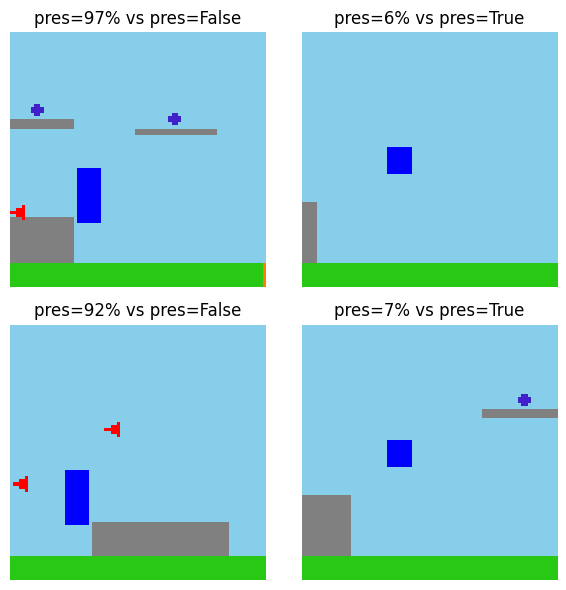

Concept: player on wall


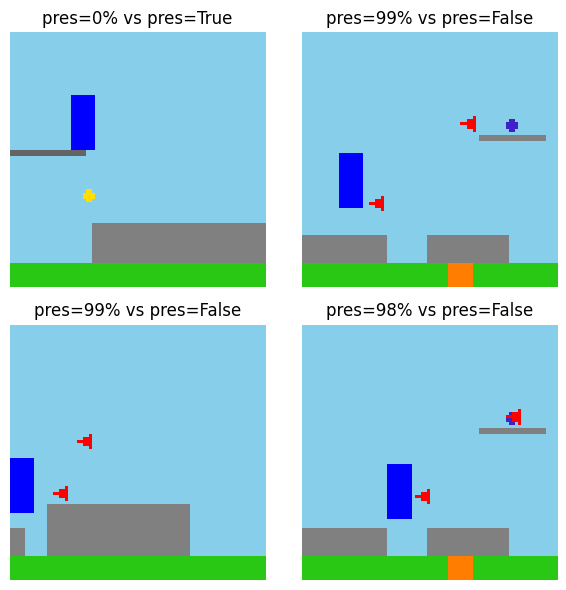

Concept: player dodging on wall


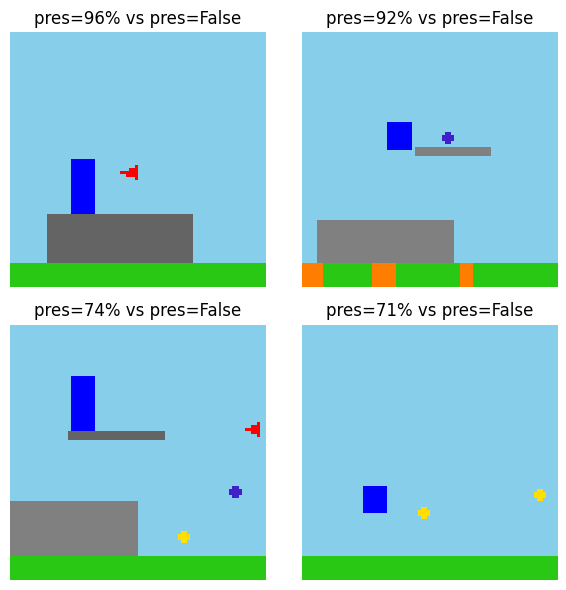

Concept: events quantity


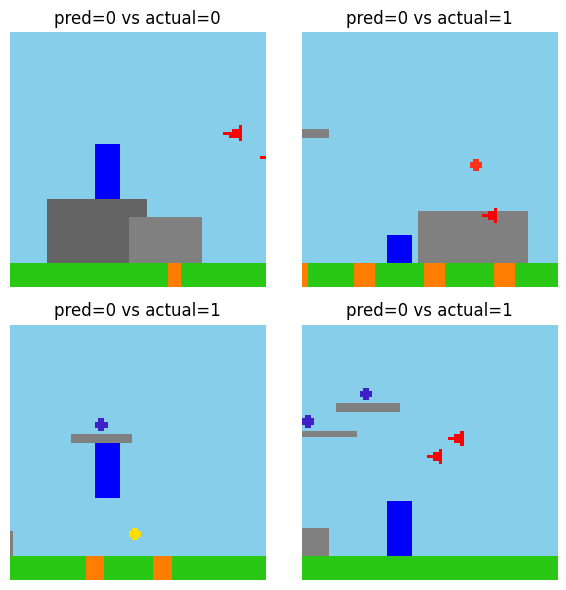

Concept: good events quantity


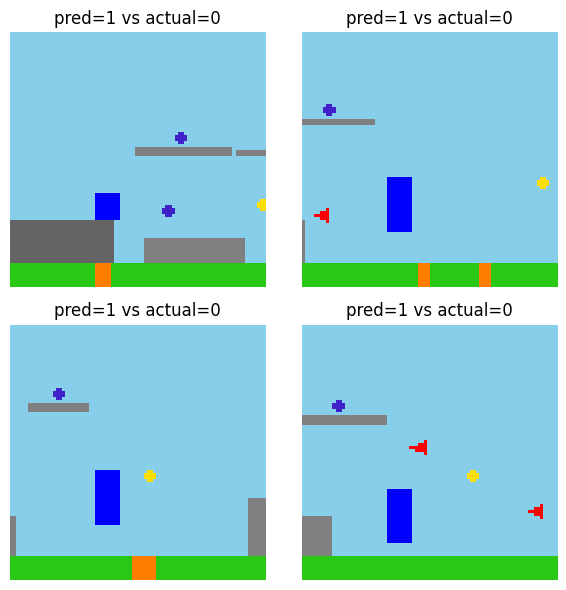

Concept: bad events quantity


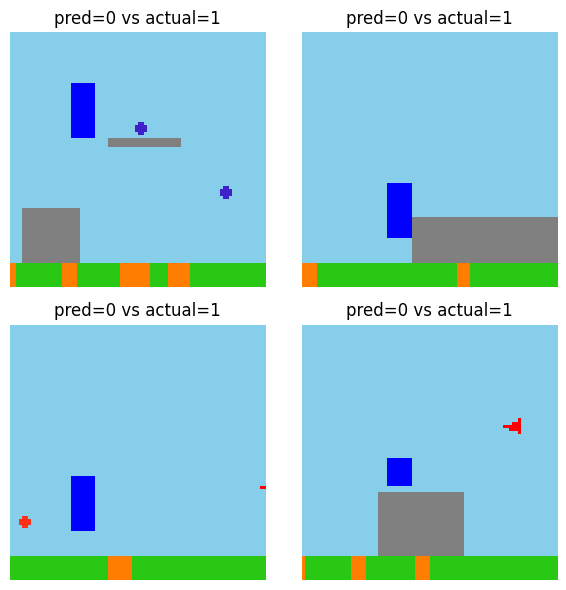

Concept: visible wall


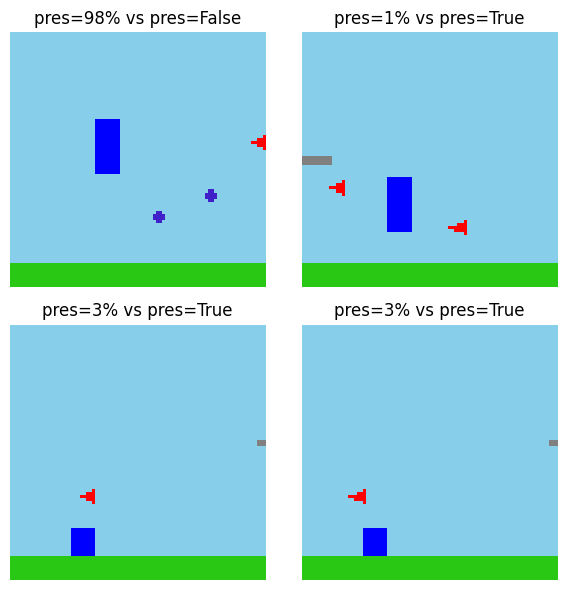

Concept: visible air wall


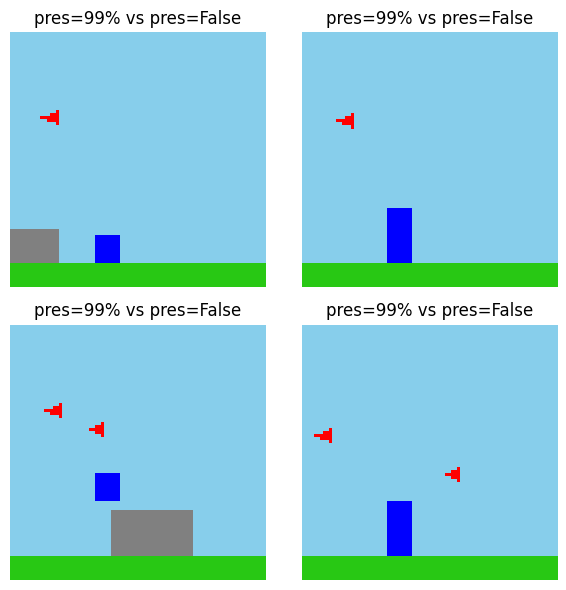

Concept: visible bullet


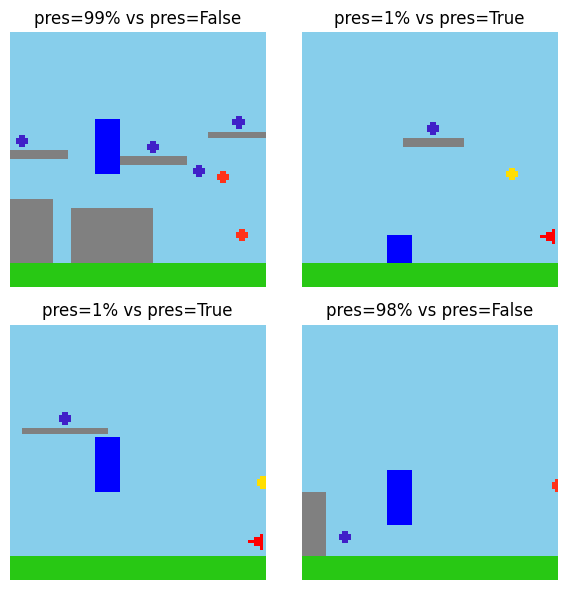

Concept: visible lava


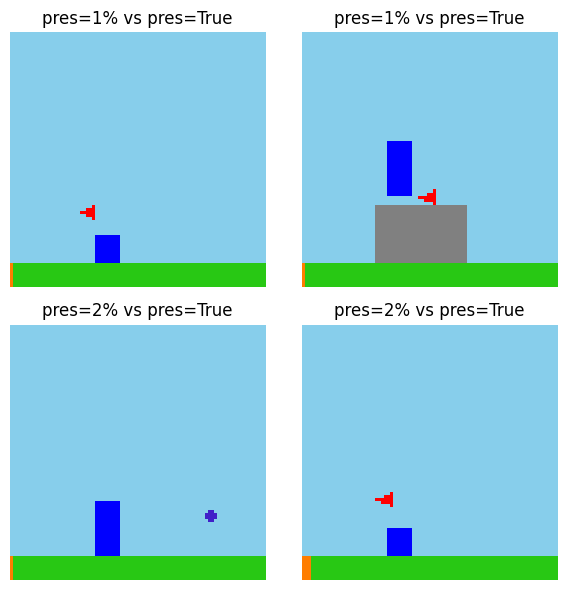

Concept: visible blue coin


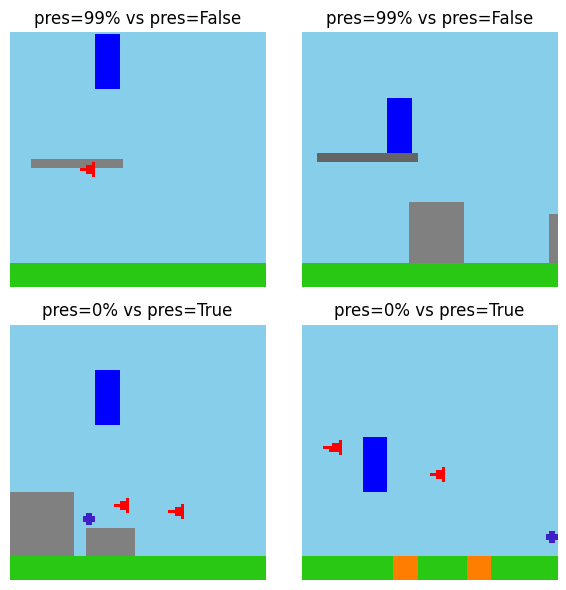

Concept: visible gold coin


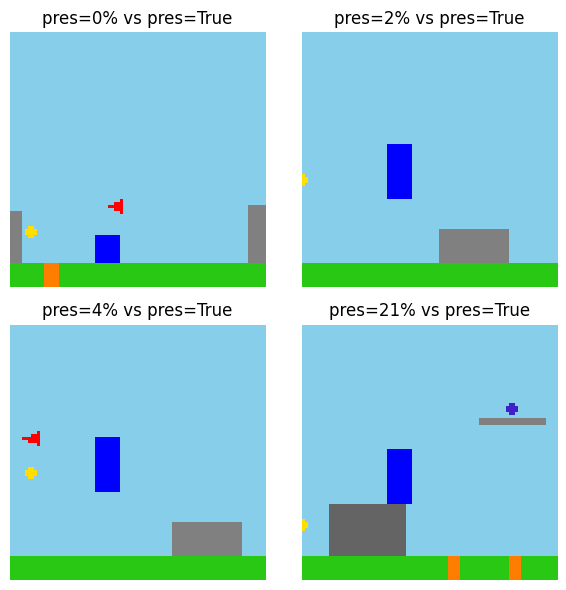

Concept: visible red coin


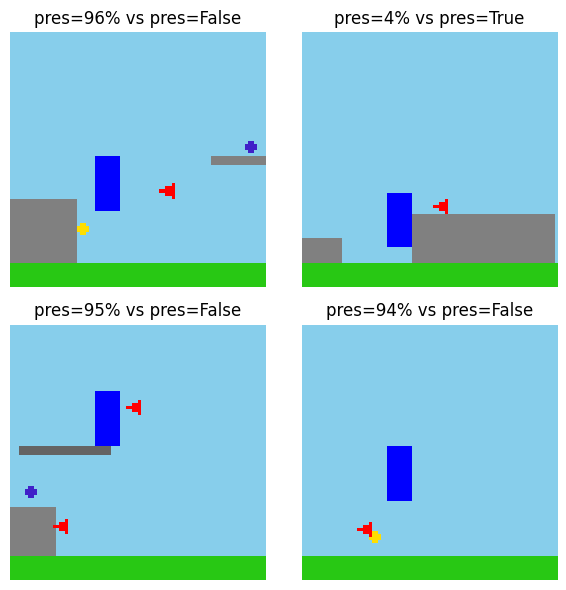

Concept: visible high coin


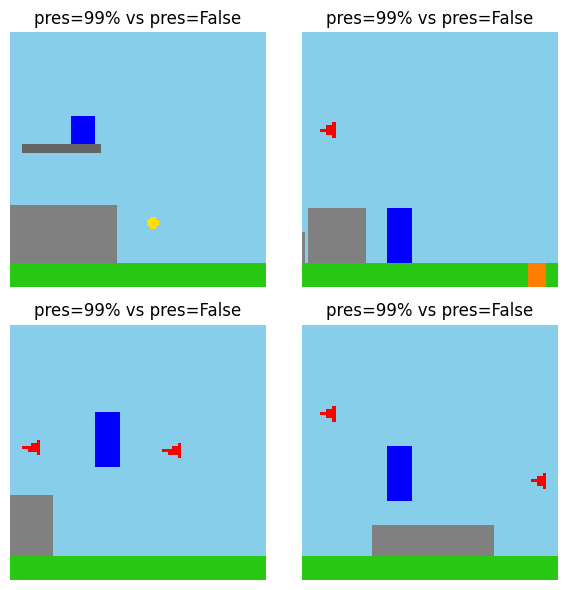

Concept: visible good low coin


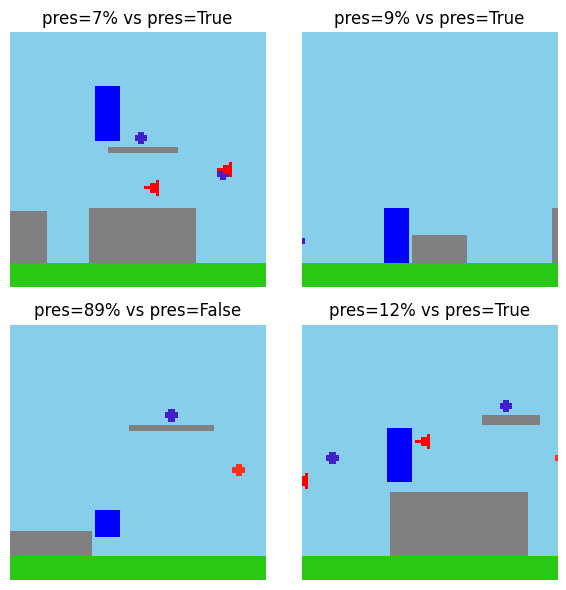

Concept: bullet close


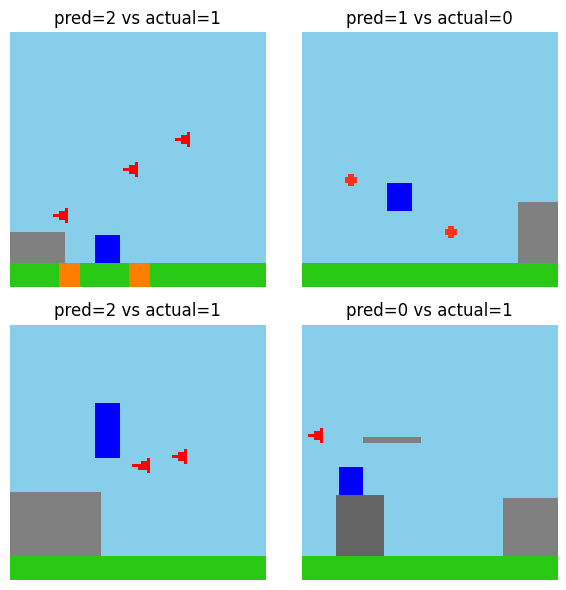

Concept: bullet aligned with player


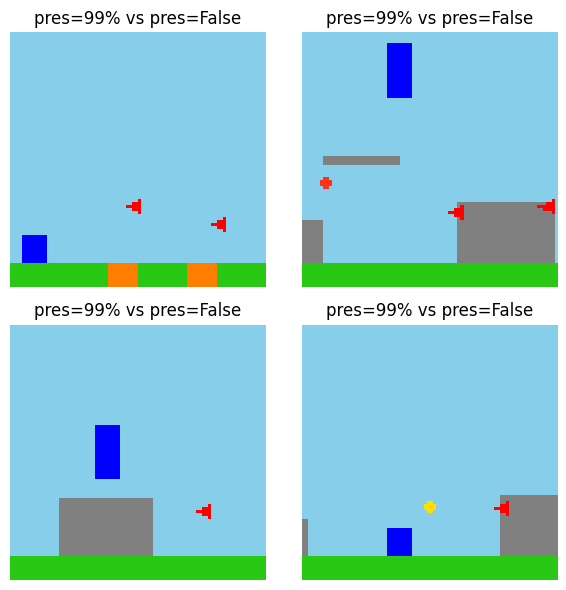

Concept: good coin left of player


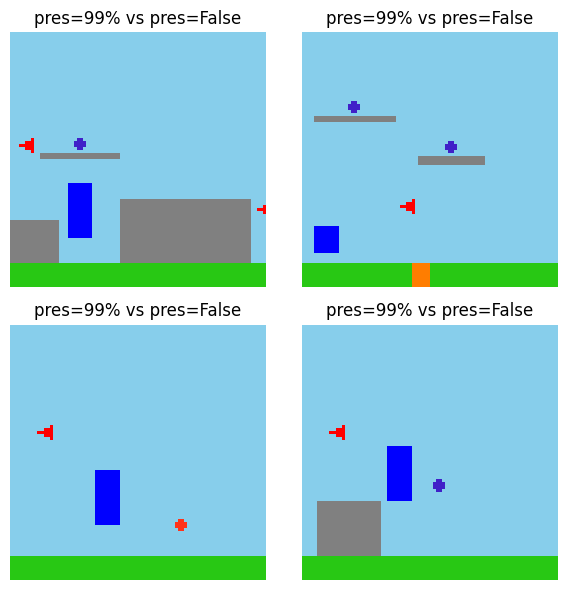

In [5]:
num_images = 4
for concept in concept_instances.values():
    print(f"Concept: {concept.name}")
    concept.prepare_data(env_steps, max_size=10000)
    test_images = concept.test_images
    test_obs = concept.test_obs
    test_values = concept.test_values
    _, test_acts_dict = model(torch.Tensor(test_obs), return_acts=True)
    test_acts = test_acts_dict[layer].detach()
    probe, score = concept.load_torch_probe()
    
    # Calculate residuals and sort them to find the worst predictions
    pred = probe(test_acts).detach().squeeze().numpy()
    residuals = np.abs(pred - test_values)
    worst = residuals.argsort()[-num_images:][::-1]
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    axes = axes.flatten()

    for idx, ax in zip(worst, axes):
        ax.imshow(concept.test_images[idx])
        if concept.binary:
            ax.set_title(f'pres={int(pred[idx]*100)}% vs pres={"True" if test_values[idx] == 1 else "False"}')
        else:
            ax.set_title(f'pred={round(pred[idx])} vs actual={round(test_values[idx])}')
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'{concept.folder_path}/worst_predictions.png')
    plt.show()